# Model - XGBoost Classifier

Overview of notebook, from Nature paper will classify each subreddit... etc.

> Modeling steps in this notebook
- TF-IDF Transform 
- Split data to training (80%) and testing (20%)
- To handle imbalanced class of our target variable we use SMOTE algorithm on the training data
- Use XGBoost Classifier 

##### Import libraries

In [73]:
import time
start = time.time()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

# Train, test, split
from sklearn.model_selection import train_test_split

# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer 

# For handling imbalanced classes
from collections import Counter
from imblearn.over_sampling import SMOTE

# For classification
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from xgboost import plot_importance 

##### Load data

In [74]:
posts = pd.read_csv('../data/posts-preprocessed.csv')

##### Binarize targets using get_dummies

Will use each subreddit as target (except mental health)

In [75]:
posts = pd.get_dummies(posts, columns=['subreddit'])

In [76]:
posts.drop(columns='subreddit_mentalhealth', inplace = True)

## Vectorize using TFIDF
Implement Term Frequency - Inverse Document Frequency (TF-IDF) to vectorize the pre-processed text from the subreddit posts into numerical representations in a weight matrix that will be the basis for our set of feature for the predictive models. TF-IDF calculates how important a word is in a document in comparison to the entire corpus

In [77]:
# Remove stop words
X = posts['word_tokens']

In [78]:
# create the transform
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

In [79]:
X = vectorizer.fit_transform(X)
vocab = vectorizer.get_feature_names()

In [80]:
df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

In [81]:
X = df

## Subreddit: Anorexia Nervosa

In [9]:
y = posts['subreddit_AnorexiaNervosa']

In [10]:
y.shape

(84886,)

### train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = .2,
                                                    random_state=42)

Check that stratify worked as expected

In [13]:
sum(y_train)/len(y_train)

0.11387465394357071

In [14]:
sum(y_test)/len(y_test)

0.11385322181646837

Summarize the class distribution of the target

### Oversample the minority class using SMOTE

In [15]:
counter = Counter(y_train)
print(counter)

Counter({0: 60175, 1: 7733})


In [16]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [17]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60175, 1: 60175})


### XGBoost Model

Define Parameters for XGBoost Model

In [18]:
feature_names = X_train.columns

In [19]:
model = XGBClassifier(feature_names = feature_names,
                      n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 84, # stop at around 84 trees, model no loger improves much after
                      random_state = 42)

In [20]:
model.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[11:02:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { feature_names, n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.45122
[1]	validation_0-aucpr:0.46561
[2]	validation_0-aucpr:0.49171
[3]	validation_0-aucpr:0.50986
[4]	validation_0-aucpr:0.51231
[5]	validation_0-aucpr:0.51913
[6]	validation_0-aucpr:0.51848
[7]	validation_0-aucpr:0.52171
[8]	validation_0-aucpr:0.52882
[9]	validation_0-aucpr:0.53144
[10]	validation_0-aucpr:0.52852
[11]	validation_0-aucpr:0.53010
[12]	validation_0-aucpr:0.53923
[13]	validation_0-aucpr:0.53569
[14]	validation_0-aucpr:0.53071
[15]	validation_0-aucpr:0.53845
[16]	validation_0-aucpr:0.53834
[17]	validation_0-aucpr:0.53902
[18]	validation_0-aucpr:0.53985
[19]	validation_0-aucpr:0.55

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              feature_names=Index(['abandoned', 'abandonment', 'ability', 'able', 'absolute', 'absolutely',
       'abuse', 'abusive', 'accept', 'accepted',
       ...
       'yeah', 'year', 'yelling', 'yes', 'yesterday', 'yet', 'young',
       'younger', 'youve', 'zero'],
      dtype='object', length=1500),
              gamma=0...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              monotone_constraints='()', n_classes=2, n_estimators=84, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

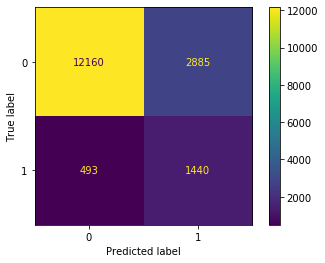

In [21]:
plot_confusion_matrix(model,
                      X_test,
                      y_test);

In [22]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.10%


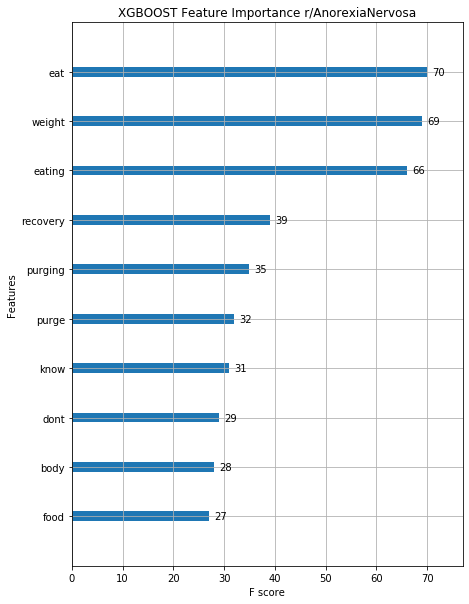

<Figure size 432x288 with 0 Axes>

In [23]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model,max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance r/AnorexiaNervosa")
plt.show()
plt.savefig('anorexia_reddit.png');

It looks like 'anorexia' was not filtered out with the stopwords, go back and check the pre-processing 

## Subreddit: Anxiety

In [24]:
y = posts['subreddit_Anxiety']

In [25]:
y.shape

(84886,)

In [26]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

In [27]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 60358, 1: 7550})


In [28]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [29]:
# summarize class distribution
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({1: 60358, 0: 60358})


In [30]:
feature_names = X_train.columns

In [31]:
model2 = XGBClassifier(feature_names = feature_names,
                       n_classes = 2, 
                       missing=None,
                       objective='binary:logistic',
                       use_label_encoder = False,
                       n_jobs = 4,
                       subsample = .8,
                       n_estimators = 14, # stop at around 14? trees, model no loger improves much after
                       random_state = 42)

In [32]:
model2.fit(X_train_sm, 
           y_train_sm,
           verbose = True, # set to true if you want to see where to stop early
           early_stopping_rounds = 10, # reduce overfitting with early stopping
           eval_metric = 'aucpr',
           eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[11:04:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { feature_names, n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.22972
[1]	validation_0-aucpr:0.23859
[2]	validation_0-aucpr:0.25039
[3]	validation_0-aucpr:0.24756
[4]	validation_0-aucpr:0.24687
[5]	validation_0-aucpr:0.24605
[6]	validation_0-aucpr:0.25013
[7]	validation_0-aucpr:0.24669
[8]	validation_0-aucpr:0.24840
[9]	validation_0-aucpr:0.25032
[10]	validation_0-aucpr:0.25428
[11]	validation_0-aucpr:0.25250
[12]	validation_0-aucpr:0.25091
[13]	validation_0-aucpr:0.25242


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              feature_names=Index(['abandoned', 'abandonment', 'ability', 'able', 'absolute', 'absolutely',
       'abuse', 'abusive', 'accept', 'accepted',
       ...
       'yeah', 'year', 'yelling', 'yes', 'yesterday', 'yet', 'young',
       'younger', 'youve', 'zero'],
      dtype='object', length=1500),
              gamma=0...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              monotone_constraints='()', n_classes=2, n_estimators=14, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

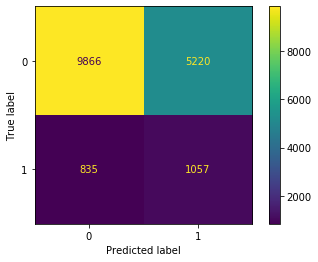

In [33]:
plot_confusion_matrix(model2,
                      X_test,
                      y_test);

In [34]:
y_pred = model2.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.34%


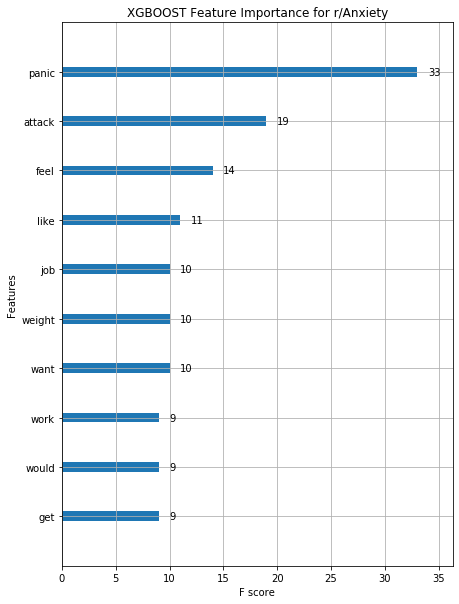

<Figure size 432x288 with 0 Axes>

In [35]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model2, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/Anxiety")
plt.show()
plt.savefig('anxiety_reddit.png');

## Subreddit: Autism

In [36]:
y = posts['subreddit_autism']

In [37]:
y.shape

(84886,)

### train test split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [39]:
counter = Counter(y_train)
print(counter)

Counter({0: 60607, 1: 7301})


### Oversample the minority class using SMOTE

In [40]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [41]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60607, 1: 60607})


### XGBoost Model

Define Parameters for XGBoost Model

In [42]:
model3 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 222, # stop at around 222 trees, model no loger improves much after
                      random_state = 42)

In [43]:
model3.fit(X_train_sm, 
          y_train_sm,
          verbose = False, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[11:07:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=222, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

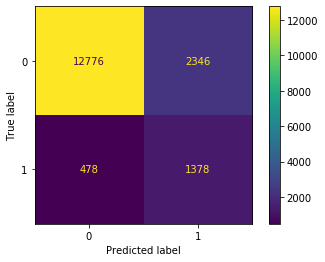

In [44]:
plot_confusion_matrix(model3,
                      X_test,
                      y_test);

In [45]:
y_pred = model3.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.37%


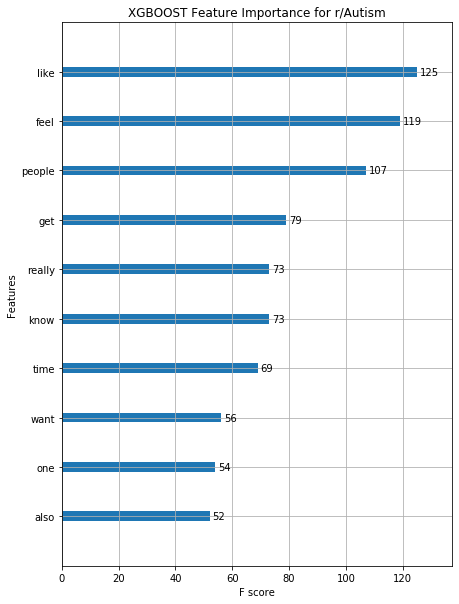

<Figure size 432x288 with 0 Axes>

In [46]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model3, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/Autism")
plt.show()
plt.savefig('autism_reddit.png');

## Subreddit: BPD

In [49]:
y = posts['subreddit_BPD']

In [50]:
y.shape

(84886,)

### train test split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [52]:
counter = Counter(y_train)
print(counter)

Counter({0: 60445, 1: 7463})


### Oversample the minority class using SMOTE

In [53]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [54]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60445, 1: 60445})


### XGBoost Model

Define Parameters for XGBoost Model

In [55]:
model4 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 200, # stop at around n trees, model no loger improves much after
                      random_state = 42)

In [56]:
model4.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[11:22:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.12997
[1]	validation_0-aucpr:0.15299
[2]	validation_0-aucpr:0.15820
[3]	validation_0-aucpr:0.18346
[4]	validation_0-aucpr:0.17991
[5]	validation_0-aucpr:0.18020
[6]	validation_0-aucpr:0.18300
[7]	validation_0-aucpr:0.18038
[8]	validation_0-aucpr:0.18807
[9]	validation_0-aucpr:0.19012
[10]	validation_0-aucpr:0.19113
[11]	validation_0-aucpr:0.21990
[12]	validation_0-aucpr:0.22228
[13]	validation_0-aucpr:0.21174
[14]	validation_0-aucpr:0.21169
[15]	validation_0-aucpr:0.21251
[16]	validation_0-aucpr:0.22291
[17]	validation_0-aucpr:0.21786
[18]	validation_0-aucpr:0.21571
[19]	validation_0-aucpr:0.21583
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=200, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [59]:
y_pred = model4.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.07%


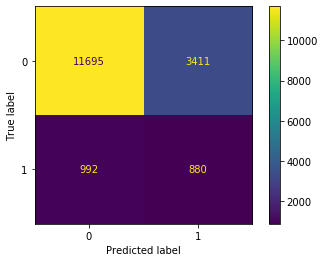

In [57]:
plot_confusion_matrix(model4,
                      X_test,
                      y_test);

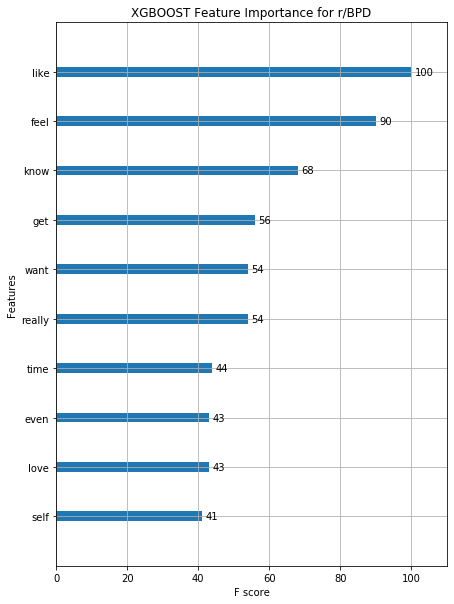

<Figure size 432x288 with 0 Axes>

In [58]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model4, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/BPD")
plt.show()
plt.savefig('BPD_reddit.png');

## Subreddit: Bipolar

In [82]:
y = posts['subreddit_bipolar']

In [83]:
y.shape

(84879,)

### train test split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [85]:
counter = Counter(y_train)
print(counter)

Counter({0: 60448, 1: 7455})


### Oversample the minority class using SMOTE

In [86]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [87]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60448, 1: 60448})


### XGBoost Model

Define Parameters for XGBoost Model

In [88]:
model5 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 200, # stop at around n trees, model no loger improves much after
                      random_state = 42)

In [89]:
model5.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[11:37:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.25791
[1]	validation_0-aucpr:0.26726
[2]	validation_0-aucpr:0.31912
[3]	validation_0-aucpr:0.32682
[4]	validation_0-aucpr:0.32814
[5]	validation_0-aucpr:0.33569
[6]	validation_0-aucpr:0.34062
[7]	validation_0-aucpr:0.35656
[8]	validation_0-aucpr:0.35316
[9]	validation_0-aucpr:0.35579
[10]	validation_0-aucpr:0.36869
[11]	validation_0-aucpr:0.37302
[12]	validation_0-aucpr:0.37442
[13]	validation_0-aucpr:0.37702
[14]	validation_0-aucpr:0.38499
[15]	validation_0-aucpr:0.38665
[16]	validation_0-aucpr:0.39304
[17]	validation_0-aucpr:0.39336
[18]	validation_0-aucpr:0.39155
[19]	validation_0-aucpr:0.39575
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=200, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [90]:
y_pred = model5.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.25%


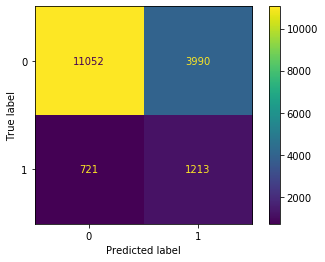

In [91]:
plot_confusion_matrix(model5,
                      X_test,
                      y_test);

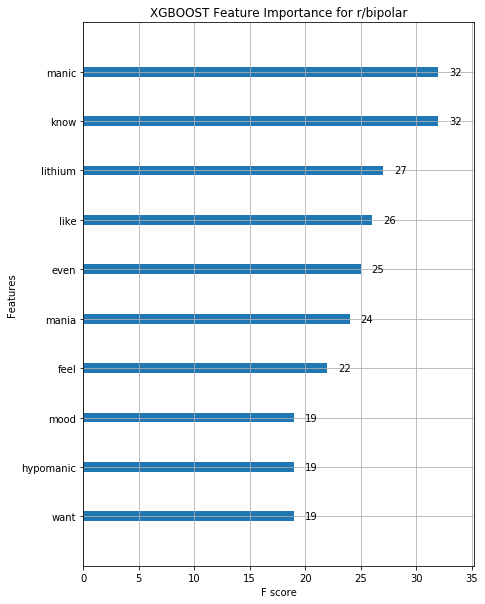

<Figure size 432x288 with 0 Axes>

In [92]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model5, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/bipolar")
plt.show()
plt.savefig('bipolar_reddit.png');

## Subreddit: Bulimia

In [94]:
y = posts['subreddit_bulimia']

In [95]:
y.shape

(84879,)

### train test split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [97]:
counter = Counter(y_train)
print(counter)

Counter({0: 60031, 1: 7872})


### Oversample the minority class using SMOTE

In [98]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [99]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60031, 1: 60031})


### XGBoost Model

Define Parameters for XGBoost Model

In [100]:
model6 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 200, # stop at around n trees, model no loger improves much after
                      random_state = 42)

In [101]:
model6.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[11:47:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.55818
[1]	validation_0-aucpr:0.57974
[2]	validation_0-aucpr:0.59806
[3]	validation_0-aucpr:0.59671
[4]	validation_0-aucpr:0.60011
[5]	validation_0-aucpr:0.59775
[6]	validation_0-aucpr:0.60454
[7]	validation_0-aucpr:0.60305
[8]	validation_0-aucpr:0.60533
[9]	validation_0-aucpr:0.60739
[10]	validation_0-aucpr:0.60557
[11]	validation_0-aucpr:0.61206
[12]	validation_0-aucpr:0.62372
[13]	validation_0-aucpr:0.62198
[14]	validation_0-aucpr:0.62233
[15]	validation_0-aucpr:0.62569
[16]	validation_0-aucpr:0.62580
[17]	validation_0-aucpr:0.62567
[18]	validation_0-aucpr:0.62570
[19]	validation_0-aucpr:0.62682
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=200, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [102]:
y_pred = model6.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.21%


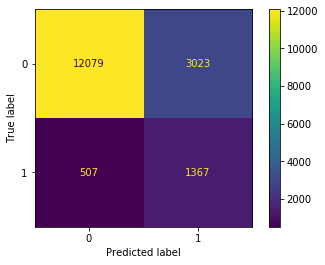

In [103]:
plot_confusion_matrix(model6,
                      X_test,
                      y_test);

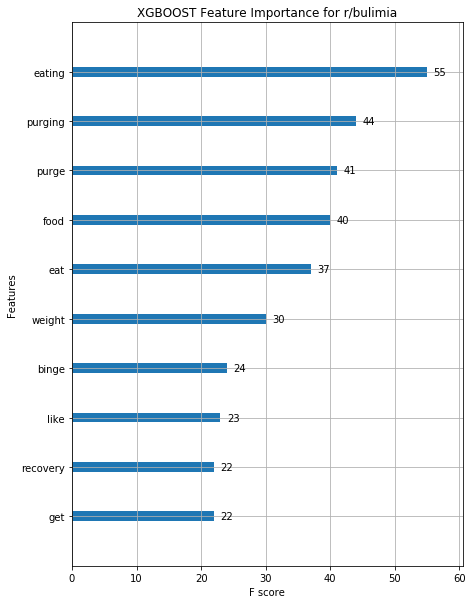

<Figure size 432x288 with 0 Axes>

In [104]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model6, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/bulimia")
plt.show()
plt.savefig('bulimia_reddit.png');

## Subreddit: Depression

In [107]:
y = posts['subreddit_depression']

In [108]:
y.shape

(84879,)

### train test split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [110]:
counter = Counter(y_train)
print(counter)

Counter({0: 60507, 1: 7396})


### Oversample the minority class using SMOTE

In [111]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [112]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60507, 1: 60507})


### XGBoost Model

Define Parameters for XGBoost Model

In [113]:
model7 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 200, # stop at around n trees, model no loger improves much after
                      random_state = 42)

In [114]:
model7.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[11:52:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.14873
[1]	validation_0-aucpr:0.15030
[2]	validation_0-aucpr:0.15301
[3]	validation_0-aucpr:0.15770
[4]	validation_0-aucpr:0.16232
[5]	validation_0-aucpr:0.19162
[6]	validation_0-aucpr:0.19153
[7]	validation_0-aucpr:0.20193
[8]	validation_0-aucpr:0.20117
[9]	validation_0-aucpr:0.20132
[10]	validation_0-aucpr:0.20769
[11]	validation_0-aucpr:0.21019
[12]	validation_0-aucpr:0.21121
[13]	validation_0-aucpr:0.21160
[14]	validation_0-aucpr:0.21624
[15]	validation_0-aucpr:0.22420
[16]	validation_0-aucpr:0.22151
[17]	validation_0-aucpr:0.22673
[18]	validation_0-aucpr:0.22398
[19]	validation_0-aucpr:0.22472
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=200, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [115]:
y_pred = model7.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.53%


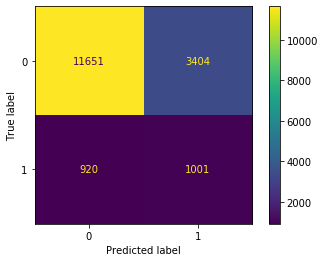

In [116]:
plot_confusion_matrix(model7,
                      X_test,
                      y_test);

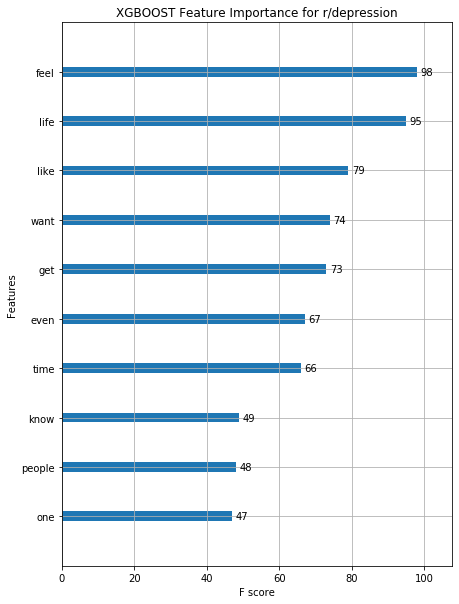

<Figure size 432x288 with 0 Axes>

In [117]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model7, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/depression")
plt.show()
plt.savefig('depression_reddit.png');

## Subreddit: Schizophrenia

In [120]:
y = posts['subreddit_schizophrenia']

In [121]:
y.shape

(84879,)

### train test split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [123]:
counter = Counter(y_train)
print(counter)

Counter({0: 60303, 1: 7600})


### Oversample the minority class using SMOTE

In [124]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [125]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60303, 1: 60303})


### XGBoost Model

Define Parameters for XGBoost Model

In [126]:
model8 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 200, # stop at around n trees, model no loger improves much after
                      random_state = 42)

In [127]:
model8.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[11:58:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.19487
[1]	validation_0-aucpr:0.19929
[2]	validation_0-aucpr:0.20391
[3]	validation_0-aucpr:0.20847
[4]	validation_0-aucpr:0.21707
[5]	validation_0-aucpr:0.22356
[6]	validation_0-aucpr:0.22351
[7]	validation_0-aucpr:0.22215
[8]	validation_0-aucpr:0.22445
[9]	validation_0-aucpr:0.22590
[10]	validation_0-aucpr:0.22749
[11]	validation_0-aucpr:0.22990
[12]	validation_0-aucpr:0.25057
[13]	validation_0-aucpr:0.25043
[14]	validation_0-aucpr:0.25231
[15]	validation_0-aucpr:0.25240
[16]	validation_0-aucpr:0.25192
[17]	validation_0-aucpr:0.25369
[18]	validation_0-aucpr:0.25328
[19]	validation_0-aucpr:0.25859
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=200, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [128]:
y_pred = model8.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.37%


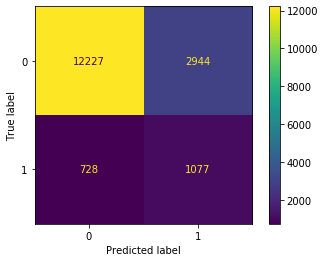

In [129]:
plot_confusion_matrix(model8,
                      X_test,
                      y_test);

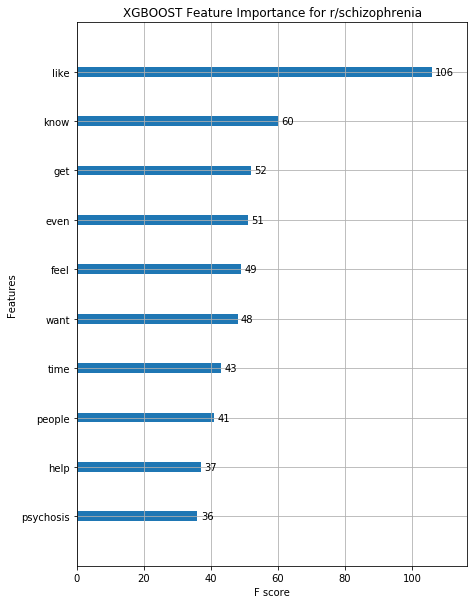

<Figure size 432x288 with 0 Axes>

In [130]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model8, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/schizophrenia")
plt.show()
plt.savefig('schizophrenia_reddit.png');

# Try XGBoost with all classes in model